In [1]:
import pandas as pd
import numpy as np 
import re
import datetime

In [2]:
columns =['type', 'id', 'subreddit.id', 'subreddit.name', 
 'subreddit.nsfw', 'created_utc', 'url', 'text', 'sent', 'score']

In [4]:
df_reddit = pd.read_csv('/home/novemillimetri/Scrivania/cap_multiplatform/data/reddit_vaccine_comments.csv',names=columns)

In [6]:
df_twitter= pd.read_csv('/home/novemillimetri/Scrivania/cap_multiplatform/data/vaccination_all_tweets.csv')

In [8]:
df_reddit['len_text'] = df_reddit['text'].str.len()

In [9]:
len(df_reddit)

3970724

In [10]:
df_reddit = df_reddit[df_reddit['len_text']<400]

In [11]:
len(df_reddit)

1594208

In [12]:
len(df_twitter)

228207

In [13]:
df_reddit.columns

Index(['type', 'id', 'subreddit.id', 'subreddit.name', 'subreddit.nsfw',
       'created_utc', 'url', 'text', 'sent', 'score', 'len_text'],
      dtype='object')

In [14]:
df_twitter.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [15]:
platformdf_twitter['date'] = pd.to_datetime(df_twitter['date'])

In [16]:
df_reddit['date'] = pd.to_datetime(df_reddit['created_utc'],unit='s')

<AxesSubplot:xlabel='date'>

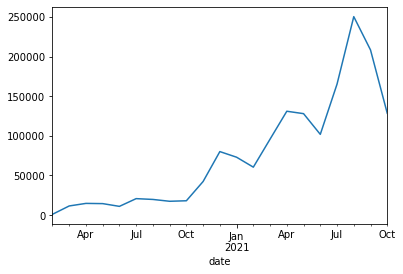

In [17]:
%matplotlib inline

df_reddit.resample('M',on='date')['id'].count().plot()

<AxesSubplot:xlabel='date'>

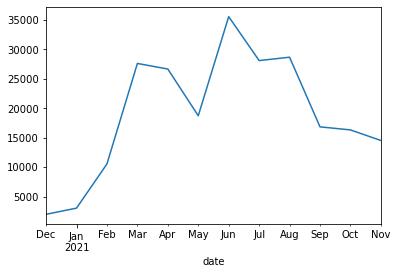

In [18]:
df_twitter.resample('M',on='date')['id'].count().plot()

In [19]:
mask_t = (df_twitter['date'] > datetime.datetime(2021,1,1)) 
mask_r = (df_reddit['date'] > datetime.datetime(2021,1,1)) 

In [20]:
df_reddit = df_reddit[mask_r]
df_twitter = df_twitter[mask_t]

In [21]:
df_reddit = df_reddit.sample(250000)

In [22]:
import matplotlib.pyplot as plt

In [23]:
reddit_counts = df_reddit.resample('M',on='date')['id'].count()#.plot()
twitter_counts = df_twitter.resample('M',on='date')['id'].count()#.plot()


In [24]:
reddit_counts.values

array([13415, 11242, 17813, 24613, 23860, 19042, 30703, 46658, 38722,
       23932])

## Andamento temporale

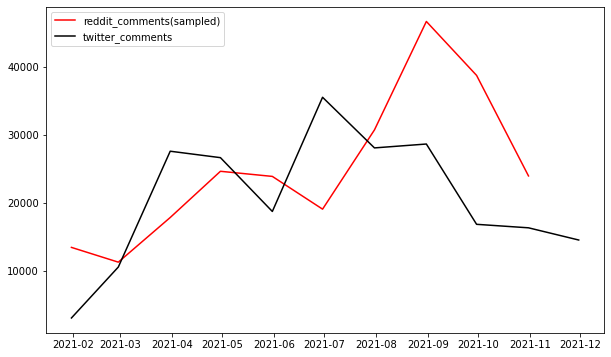

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(10,6))
plt.plot(reddit_counts.index, reddit_counts.values, label = "reddit_comments(sampled)", color='red')
plt.plot(twitter_counts.index, twitter_counts.values, label = "twitter_comments", color='black')

plt.legend()
plt.show()

## reputation  distribution 

In [26]:
def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n


In [27]:
gini(df_twitter.retweets.values.tolist())

0.9528807302564807

In [28]:
gini(df_reddit.score.values.tolist())

0.9511297737918527

## sentiment analysis 

In [30]:
#!pip install textblob


from nltk.corpus import stopwords
from textblob import TextBlob


stop = stopwords.words('english')






     |████████████████████████████████| 636 kB 1.5 MB/s eta 0:00:01


In [31]:
def sentiment(text):
    doc = TextBlob(text)
    
    return doc.sentiment.polarity

In [32]:
df_twitter['sent'] = df_twitter['text'].apply(sentiment)

<ipython-input-32-af9dd691000c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitter['sent'] = df_twitter['text'].apply(sentiment)


In [33]:
df_reddit['sent'] = df_reddit['text'].apply(sentiment)

In [31]:
df_reddit['sent'].mean()

0.05933909959675549

In [34]:
df_twitter['sent'].mean()

0.08800343782769993

In [35]:
sent_avg_r = df_reddit.resample('M',on='date')['sent'].mean()
sent_avg_t = df_twitter.resample('M',on='date')['sent'].mean()

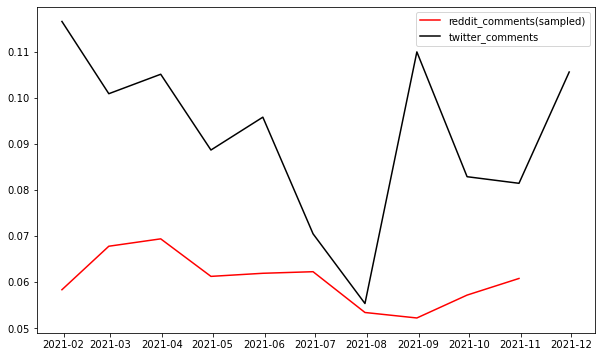

In [36]:


plt.figure(figsize=(10,6))
plt.plot(sent_avg_r.index, sent_avg_r.values, label = "reddit_comments(sampled)", color='red')
plt.plot(sent_avg_t.index, sent_avg_t.values, label = "twitter_comments", color='black')


plt.legend()
plt.show()

In [37]:
#conta delle key
#sentiment per key per dataset

In [75]:
keys= ['astrazeneca','pfizer','biontech','sinopharm','moderna','covaxin','sputnik','vaccine']

In [76]:
for key in keys:
    df_twitter[key]= df_twitter['text'].str.contains(key)
    df_reddit[key] = df_reddit['text'].str.contains(key)
    


<ipython-input-76-bdd121aa4283>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitter[key]= df_twitter['text'].str.contains(key)


In [77]:
sent_per_key=[]
n_per_key=[]
time_series={}

for key in keys:
    row={}
    short_df=df_twitter[df_twitter[key]==True]
    n_per_key.append({'key':key,'count':len(short_df)})
    row['brand']=key
    row['sent']=short_df['sent'].mean()
    
    time_series[key]=short_df.resample('M',on='date')['sent'].mean()
    sent_per_key.append(row)
    
    

In [78]:
sent_df_t=pd.DataFrame(sent_per_key)
n_df_t = pd.DataFrame(n_per_key)

<AxesSubplot:xlabel='key'>

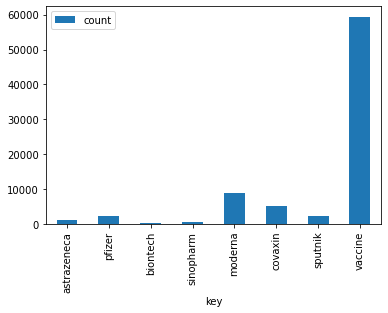

In [79]:
n_df_t.plot.bar('key','count')

<AxesSubplot:xlabel='brand'>

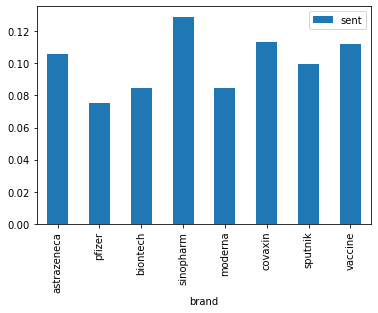

In [80]:
sent_df_t.plot.bar('brand','sent')

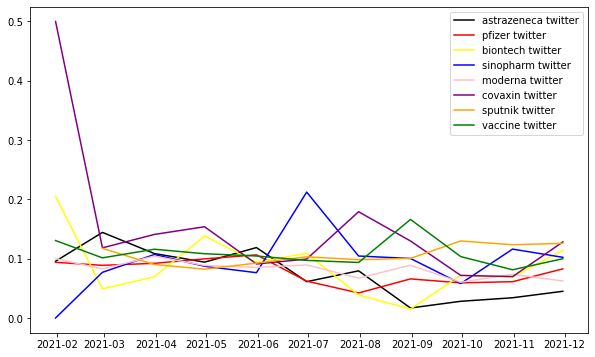

In [81]:


plt.figure(figsize=(10,6))


colors=['black','red','yellow','blue','pink','purple','orange','green','grey']

for i,key in enumerate(keys):
    plt.plot(time_series[key].index,time_series[key].values,label=key+' twitter',color=colors[i])



plt.legend()
plt.show()

In [82]:
# reddit

sent_per_key=[]
n_per_key=[]
time_series={}

for key in keys:
    row={}
    short_df=df_reddit[df_reddit[key]==True]
    n_per_key.append({'key':key,'count':len(short_df)})
    row['brand']=key
    row['sent']=short_df['sent'].mean()
    
    time_series[key]=short_df.resample('M',on='date')['sent'].mean()
    sent_per_key.append(row)
    
    

In [83]:
sent_df_r=pd.DataFrame(sent_per_key)
n_df_r = pd.DataFrame(n_per_key)

<AxesSubplot:xlabel='key'>

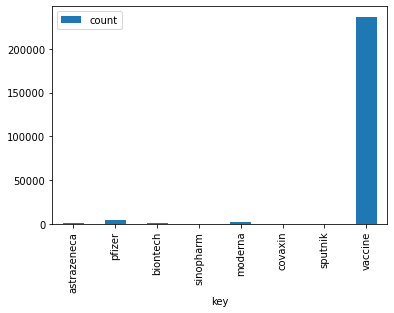

In [84]:
n_df_r.plot.bar('key','count')

<AxesSubplot:xlabel='key'>

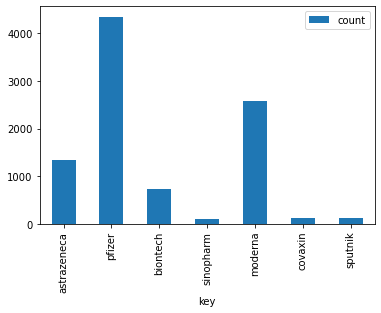

In [85]:
# togliendo le menzioni dei vaccini

n_df_r[:-1].plot.bar('key','count')

<AxesSubplot:xlabel='brand'>

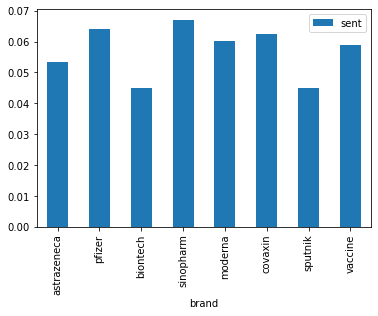

In [86]:
sent_df_r.plot.bar('brand','sent')

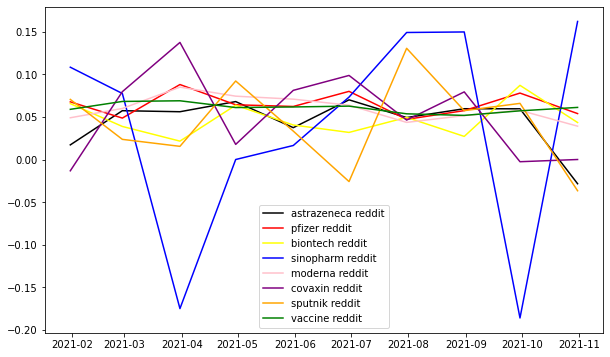

In [87]:
plt.figure(figsize=(10,6))


colors=['black','red','yellow','blue','pink','purple','orange','green','grey']

for i,key in enumerate(keys):
    plt.plot(time_series[key].index,time_series[key].values,label=key+' reddit',color=colors[i])

plt.legend()
plt.show()

## Analisi testo

In [88]:
import preprocessor as p
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

# qui si possono inserire diversi parametri v https://pypi.org/project/tweet-preprocessor/
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.NUMBER, p.OPT.HASHTAG)

In [89]:
lemmatizer = WordNetLemmatizer()
  

def clean_tweets(text):
    return p.clean(text)

def remove_url(text):
       return  re.sub(r'http\S+', '', text, flags=re.MULTILINE)


def remove_noalpha(text):
    
    text =  re.sub(r'[^\w\s]', '', text)
    return re.sub(r'[0-9]', '', text)

def remove_stopwords(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split() if w not in stop and len(w)>2 ])



In [90]:
def generate_tf_idf(texts):
    tf_idf_values={}
    docs = [value for value in texts.values()]
    tfIdfVectorizer=TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform(docs)

    for n,cl in enumerate(list(texts.keys())):
        df_tfidf = pd.DataFrame(tfIdf[n].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"]).sort_values('TF-IDF', ascending=False)
    
        tf_idf_values[cl] = df_tfidf

    df_tf_idf_all = pd.DataFrame() 

    for cl in texts.keys():
        df_tf_idf_all['tfidf_'+str(cl)] = tf_idf_values[cl]['TF-IDF']

    tf_idf_cols = df_tf_idf_all.columns.tolist()

    for col in tf_idf_cols:
          df_tf_idf_all[re.sub('tf_idf_','',col)+'_max'] = np.where(col  == df_tf_idf_all[tf_idf_cols].idxmax(axis=1),True,False)
    return df_tf_idf_all

In [91]:
# per velocizzare estraiamo un sample di 10000 items


shortlist_r = df_reddit.sample(10000)
shortlist_t = df_twitter.sample(10000)

In [92]:
#pulizia twitter

shortlist_t['clean_text'] = shortlist_t['text'].str.lower().apply(clean_tweets)
shortlist_t['clean_text'] = shortlist_t['clean_text'].str.lower().apply(remove_noalpha)
shortlist_t['clean_text'] = shortlist_t['clean_text'].str.lower().apply(remove_stopwords)





In [93]:
#pulizia reddit

shortlist_r['clean_text'] = shortlist_r['text'].str.lower().apply(remove_url)
shortlist_r['clean_text'] = shortlist_r['clean_text'].apply(remove_noalpha)
shortlist_r['clean_text'] = shortlist_r['clean_text'].apply(remove_stopwords)


In [94]:
#generiamo una booleana, True se sentiment positivo

shortlist_t['sent_pos'] = np.where(shortlist_t['sent']>0,True,False)
shortlist_r['sent_pos'] = np.where(shortlist_r['sent']>0,True,False)

In [95]:
docs={}

categories =shortlist_t['sent_pos'].unique().tolist()


for category in categories:
    text_in_category = shortlist_t[shortlist_t['sent_pos']==category]['clean_text'].tolist()
    docs[category] = ' '.join(text_in_category)
    

In [96]:
df_tf = generate_tf_idf(docs)

In [97]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [98]:
#wordcloud per sentiment positivo (True) o negativo (False) Twitter


word_clouds=[]

for cl in docs.keys():
    
    
    filtered_df = df_tf[df_tf['tfidf_'+str(cl)+'_max']==True]
    wc = WordCloud(background_color="black", max_words=500, colormap='Reds')

    wc.generate_from_frequencies(filtered_df['tfidf_'+str(cl)].to_dict())
    
    
    wc_dic = {'class':cl,'wc':wc}
    word_clouds.append(wc_dic)

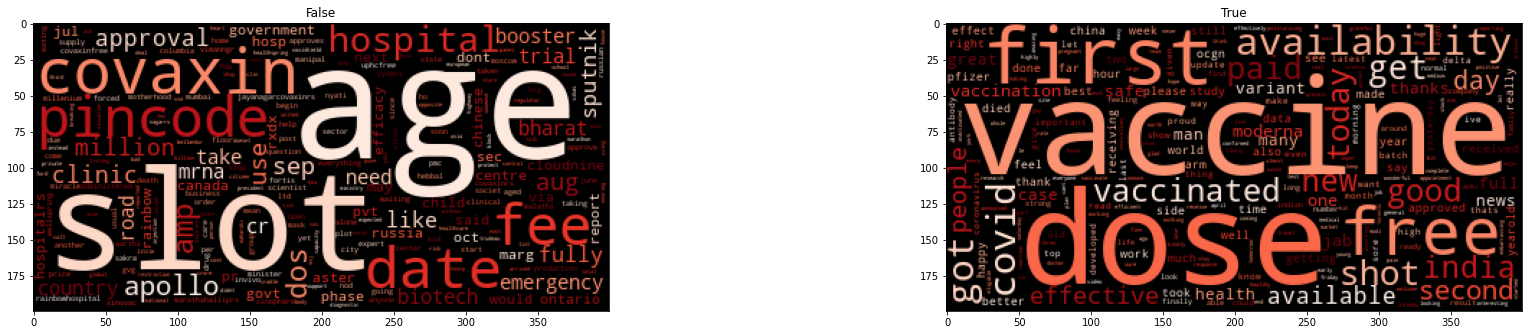

In [99]:
fig = plt.figure(figsize=(30,18))
for i in range(len(word_clouds)):
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(word_clouds[i]['wc'])
    ax.set_title(word_clouds[i]['class'])


In [100]:
docs={}

for category in categories:
    text_in_category = shortlist_r[shortlist_r['sent_pos']==category]['clean_text'].tolist()
    docs[category] = ' '.join(text_in_category)
    

In [101]:
df_tf = generate_tf_idf(docs)

In [102]:
#wordcloud per sentiment positivo (True) o negativo (False) Reddit

word_clouds=[]

for cl in docs.keys():
    
    
    filtered_df = df_tf[df_tf['tfidf_'+str(cl)+'_max']==True]
    wc = WordCloud(background_color="black", max_words=500, colormap='Reds')

    wc.generate_from_frequencies(filtered_df['tfidf_'+str(cl)].to_dict())
    
    
    wc_dic = {'class':cl,'wc':wc}
    word_clouds.append(wc_dic)

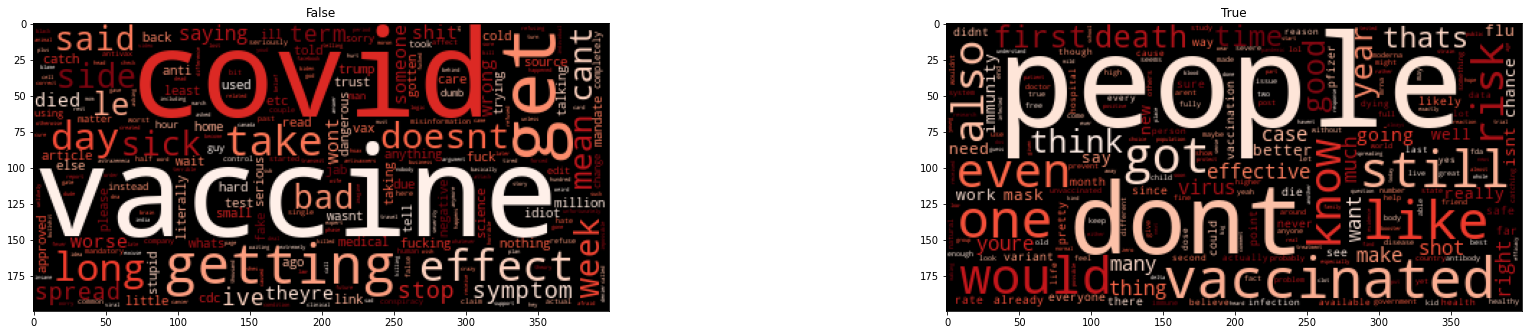

In [103]:
fig = plt.figure(figsize=(30,18))
for i in range(len(word_clouds)):
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(word_clouds[i]['wc'])
    ax.set_title(word_clouds[i]['class'])


## Analisi per piattaforma

In [104]:
docs={}


docs['twitter'] = ' '.join(shortlist_t['clean_text'].tolist())
docs['reddit'] = ' '.join(shortlist_r['clean_text'].tolist())

In [105]:
df_tf = generate_tf_idf(docs)

In [106]:
word_clouds=[]

for cl in docs.keys():
    
    
    filtered_df = df_tf[df_tf['tfidf_'+str(cl)+'_max']==True]
    wc = WordCloud(background_color="black", max_words=500, colormap='Reds')

    wc.generate_from_frequencies(filtered_df['tfidf_'+str(cl)].to_dict())
    #wc_tf_idf[str(cl)] = wc
    
    wc_dic = {'class':cl,'wc':wc}
    word_clouds.append(wc_dic)

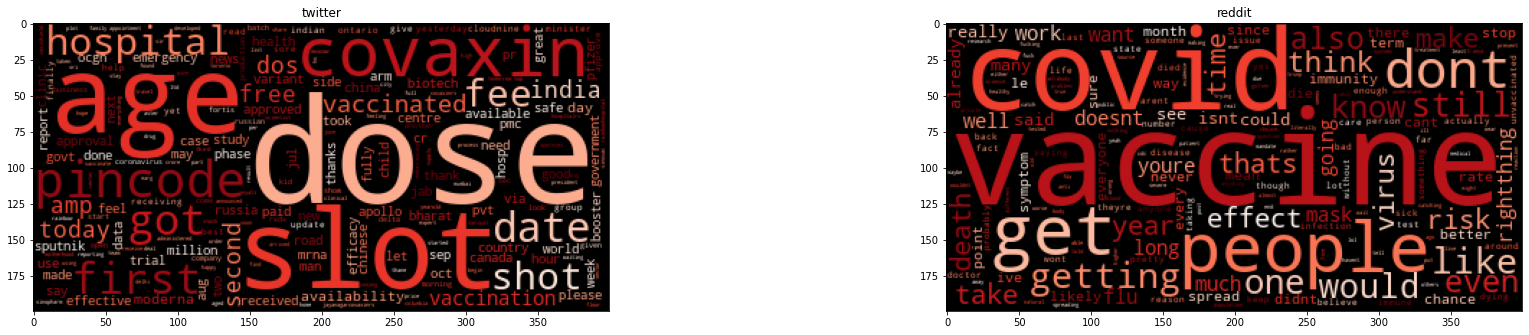

In [107]:
fig = plt.figure(figsize=(30,18))
for i in range(len(word_clouds)):
    ax = fig.add_subplot(3,2,i+1)
    ax.imshow(word_clouds[i]['wc'])
    ax.set_title(word_clouds[i]['class'])
